<a href="https://colab.research.google.com/github/prokorpio/everything_190/blob/master/SNIP_reimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SNIP Reimplementation

## 1. Import Libraries


In [1]:
import time

import numpy as np
import tensorflow as tf
print('Tensorflow v', tf.__version__, sep='')
from platform import python_version
print('python v',python_version(), sep='')
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

import keras.backend as K
import keras
print('Keras v',keras.__version__,sep='')

Tensorflow v1.15.0-rc3
python v3.6.8
Keras v2.2.5


Using TensorFlow backend.


## 2. Setup Dataset

In [2]:
# load mnist
(x, y), (x_test, y_test) = mnist.load_data()
img_size = x.shape[1:] # shape = [m, h, w]

# normalize
x = x.astype('float32')/255
x_test = x_test.astype('float32')/255

# split train:validation as 90%:10%
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, shuffle=False)

# convert y labels to one-hot vectors
num_classes = len(np.unique(y_test))
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

# view sample shape
print('x_train shape:',x_train.shape)
print('x_valid shape:',x_valid.shape)
print('y_valid shape:',y_valid.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (54000, 28, 28)
x_valid shape: (6000, 28, 28)
y_valid shape: (6000, 10)


## 3. Create Model

### 3.1 Define Custom Layers 

In [0]:
# source: https://stackoverflow.com/questions/50290769/specify-connections-in-nn-in-keras

class PrunableDense(Dense):

    def __init__(self,units,mask,**kwargs):
          
        self.mask = mask         

        #initalize the original Dense with all the usual arguments   
        super(PrunableDense,self).__init__(units,**kwargs)  


    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.mask)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

In [4]:
# define simple network
X_input = Input(shape = 4) 
X = PrunableDense(3,
                  mask=tf.Variable([[0,0,0],[1,1,1],[1,1,1],[1,1,1]],
                                   dtype = 'float32',
                                   trainable=False),
                  kernel_initializer = tf.keras.initializers.Constant(value=2),
                  use_bias=0)(X_input)
X = PrunableDense(2,
                  mask= np.array([[1,1],[1,1],[1,1]]),
                  kernel_initializer = tf.keras.initializers.Constant(value=2),
                  use_bias=0)(X)
X = Dense(1,
          kernel_initializer = tf.keras.initializers.Constant(value=1),
          use_bias = 0)(X)

model = Model(inputs=X_input, outputs=X)

model.summary()
for layer in model.trainable_weights:
    print(layer.shape)
    #print(layer.get_weights()[1].shape)
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
prunable_dense (PrunableDens (None, 3)                 24        
_________________________________________________________________
prunable_dense_1 (PrunableDe (None, 2)                 6         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 32
Trainable params: 20
Non-trainable params: 12
_________________________________________________________________
(4, 3)
(3, 2)
(2, 1)


In [5]:
inputa = np.ones(shape=(2,4)) #2 samples, 4 features
print(inputa)
model.predict(inputa)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]]


array([[72.],
       [72.]], dtype=float32)

In [0]:


grad = K.gradients(model.outputs,model.trainable_weights)

trainingExample = np.ones(shape=(2,4))
#tf.InteractiveSession().close()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
evaluated_gradients = sess.run(grad,feed_dict={model.input:trainingExample})
sess.close()

In [8]:
print(evaluated_gradients)

[array([[0., 0., 0.],
       [8., 8., 8.],
       [8., 8., 8.],
       [8., 8., 8.]], dtype=float32), array([[12., 12.],
       [12., 12.],
       [12., 12.]], dtype=float32), array([[72.],
       [72.]], dtype=float32)]


In [0]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
i = 0
grads = {0:0,1:0}
for layer in model.layers[1:]:
    grads[i] = K.gradients(model.outputs,model.trainable_weights)
    i+=1

### 3.2 Construct Custom Model

In [4]:
def LeNet_300_100(input_shape, num_classes,mask=[1,1,1]):
    """ 
    LeNet 3-Layer FC implementation
    """
    
    vs = VarianceScaling()
    
    X_input = Input(shape = input_shape)
    X = Flatten()(X_input) # 28 * 28 = 784
    X = PrunableDense(300, 
                      mask = mask[0],
                      use_bias = False,
                      kernel_initializer = vs,
                      activation='relu')(X) 
    X = PrunableDense(100,
                      mask = mask[1],
                      use_bias = False,
                      kernel_initializer = vs,
                      activation='relu')(X)
    X = PrunableDense(num_classes, 
                      mask = mask[2],
                      use_bias = False,
                      kernel_initializer = vs,
                      activation='softmax')(X)
    
    return Model(inputs=X_input, outputs=X)

LeNet = LeNet_300_100(img_size, num_classes)
LeNet.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
prunable_dense (PrunableDens (None, 300)               235200    
_________________________________________________________________
prunable_dense_1 (PrunableDe (None, 100)               30000     
_________________________________________________________________
prunable_dense_2 (PrunableDe (None, 10)                1000      
Total params: 266,200
Trainable params: 266,200
Non-trainable params: 0
_________________________________________________________________


## 4. Train Model

In [5]:
# setup Hyperparams
SGDdizer = SGD(lr=0.1,
               momentum = 0.9,
               decay = 0.0005)
LeNet.compile(optimizer=SGDdizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 100
epochs = 10
    
# fit model
trainings = []

start_time = time.time()
trainings.append(LeNet.fit(
                  x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_data = (x_valid, y_valid)))
elapsed_time = time.time() - start_time

time.strftime("Total training time  = %H:%M:%S", time.gmtime(elapsed_time))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s 53us/sample - loss: 0.2667 - acc: 0.9184 - val_loss: 0.1118 - val_acc: 0.9668
Epoch 2/10
54000/54000 [==============================] - 2s 37us/sample - loss: 0.0928 - acc: 0.9713 - val_loss: 0.0852 - val_acc: 0.9737
Epoch 3/10
54000/54000 [==============================] - 2s 37us/sample - loss: 0.0575 - acc: 0.9821 - val_loss: 0.0793 - val_acc: 0.9767
Epoch 4/10
54000/54000 [==============================] - 2s 37us/sample - loss: 0.0372 - acc: 0.9887 - val_loss: 0.0711 - val_acc: 0.9793
Epoch 5/10
54000/54000 [==============================] - 2s 36us/sample - loss: 0.0235 - acc: 0.9929 - val_loss: 0.0725 - val_acc: 0.9797
Epoch 6/10
54000/54000 [==============================] - 2s 36us/sample - loss: 0.0147 - acc: 0.9958 - val_loss: 0.0663 - val_acc: 0.9830
Epoch 7/10
54000/54000 [==============================] - 2s 36us/sample - loss: 0.0092 - acc: 0.9977 - val_loss: 0.0

'Total training time  = 00:00:25'

## 5. Results

In [0]:
def plot_trainings(trainings):
    plt.clf()
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    # concatenate all data points for all trainings
    for train in trainings:
        for point in train.history['acc']:
            acc.append(point)
        for point in train.history['val_acc']:
            val_acc.append(point)
        for point in train.history['loss']:
            loss.append(point)
        for point in train.history['val_loss']:
            val_loss.append(point)
    #epochs = range(1, len(mae) + 1)

    # Plot training history for accuracy
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

10000/10000 [==============================] - 0s 26us/sample - loss: 0.0593 - acc: 0.9838


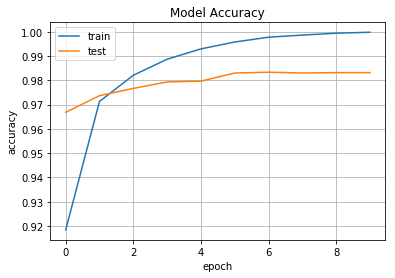


Test Error: 1.62%



In [7]:
preds = LeNet.evaluate(x_test, y_test, batch_size=batch_size)
plot_trainings(trainings)
print("\nTest Error: {:.2%}\n".format(1-preds[1])) # should get 1.65ish error

# II. Perform SNIP

In [8]:
# create initial mask matrix (all ones), using LeNet ^^
mask = []
for layer in LeNet.trainable_weights:
    #print(layer.shape)
    mask.append(tf.Variable(np.ones(layer.shape),
                            trainable = False,
                            dtype = 'float32'))
for i, _ in enumerate(mask):
    print('Mask for layer ', i+1,':',sep='')
    print(mask[i])

LeNet_to_Prune = LeNet_300_100(img_size, num_classes,mask=mask)

Mask for layer 1:
<tf.Variable 'Variable:0' shape=(784, 300) dtype=float32_ref>
Mask for layer 2:
<tf.Variable 'Variable_1:0' shape=(300, 100) dtype=float32_ref>
Mask for layer 3:
<tf.Variable 'Variable_2:0' shape=(100, 10) dtype=float32_ref>


In [9]:
# Compute Gradient wrt Mask
labels = y_train[:100] # mini-batch of 100 on MNIST from Experiment Setup Section
loss = K.mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=LeNet_to_Prune.outputs))
grads = K.gradients(loss, mask) # get gradient of loss wrt mask

trainingExample = x_train[:100]
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
evaluated_grads = sess.run(grads,feed_dict={LeNet_to_Prune.input:trainingExample})
sess.close()

print('Grads shape per layer')
for layer in evaluated_grads:
    print(layer.shape)

Grads shape per layer
(784, 300)
(300, 100)
(100, 10)


In [10]:
# convert grads to a dictionary for matrix pruning and reconstruction
# each weight should have an associated key
model_layers = []
for index, layer in enumerate(evaluated_grads):
    print('Shape of layer',index+1, '=', layer.shape)
    #print(type(layer))
    model_layers.append({key:abs(grad) for key, grad in np.ndenumerate(layer)})
                         # key of a weight is its position in tuple form
                         # note, absolute value is already taken here
    print('sample grad value:', model_layers[index][(99,9)]) # sanity check
    print('vectorized? ', np.array(list(model_layers[index].values())).shape)

Shape of layer 1 = (784, 300)
sample grad value: 4.1002355e-07
vectorized?  (235200,)
Shape of layer 2 = (300, 100)
sample grad value: 2.4637693e-06
vectorized?  (30000,)
Shape of layer 3 = (100, 10)
sample grad value: 6.622849e-06
vectorized?  (1000,)


In [11]:
# I. Normalize and get sensitivity per weight

## 1. get sum of all grads
sum_of_grads = 0
for layer in model_layers: # layer = {(row, col) : grad_of_weight}
    sum_in_layer = sum(layer.values())
    #print(sum_in_layer)
    sum_of_grads += sum_in_layer
print('overall sum =',sum_of_grads)

## 2. normalize each grad
model_layers_normed = []
for index, layer in enumerate(model_layers):
    model_layers_normed.append({key:0 for key in layer.keys()})
    for key in model_layers_normed[index].keys():
        model_layers_normed[index][key] = layer[key]/sum_of_grads

overall sum = 0.6853408043732447


In [13]:
# II. Get position of Top-K weights with highest sensitivity scores
target_sparsity = 0.95 #(m-k)/m, where m is total params and k is non_zero w

## x. Count total parameter values
total_params = 0
for i, layer_weights in enumerate(LeNet_to_Prune.trainable_weights):
    total_params += int(np.prod(layer_weights.shape))
print("# of total params =",total_params)

kappa = int(round(total_params * (1. - target_sparsity)))
print("# of weights to keep =", kappa)

## x. SortDescending
### concatenate the per layer dicts into 1 dict
all_model_grads = {}
for index, layer in enumerate(model_layers_normed):
    all_model_grads.update({(index+1,) + key : grad for key, grad in layer.items()})
                           # new key value = (layer,row,col)
print('num of items =', len(all_model_grads))
print('sample key:', list(all_model_grads.keys())[33] )
print('sample value:', list(all_model_grads.values())[33])  
print('check sum of all normed values = ',sum(all_model_grads.values()))

### sort keys using values
keys = list(all_model_grads.keys())
values = list(all_model_grads.values())
sorted_keys = sorted(all_model_grads.keys(), 
                     key=lambda k: all_model_grads[k],
                     reverse = True)

# get 1st k keys
top_k_keys = sorted_keys[:kappa]

# create mask of zeros
pruning_mask = [] # list of np arrays
for layer in evaluated_grads:
    pruning_mask.append(np.zeros(layer.shape))
    
for i, _ in enumerate(pruning_mask):
    print('Mask for layer ', i+1,':',sep='')
    print(pruning_mask[i].shape)
    
# loop on the keys, and set mask value to 1
for layer,row,col in top_k_keys:
    pruning_mask[layer-1][row,col] = 1

zero_norm = 0 # for sanity check
for layer in pruning_mask:
    zero_norm += np.sum(layer)
print('zero norm =',zero_norm)
print('kappa =', kappa)

# convert to tf.Variable
#for layer_mask in pruning_mask:
#    pruning_mask = tf.Variable(layer_mask,
#                              dtype = 'float32',
#                              trainable=False)

# determine if python is pass by ref, 
# if yes then change mask
# if not re-init

# filter
# transform to mask(0,1)

# of total params = 266200
# of weights to keep = 13310
num of items = 266200
sample key: (1, 0, 33)
sample value: 0.0
check sum of all normed values =  1.0000000000000113
Mask for layer 1:
(784, 300)
Mask for layer 2:
(300, 100)
Mask for layer 3:
(100, 10)
zero norm = 13310.0
kappa = 13310


In [14]:
# more desired to just modify the mask of previous model's layers, 
#    instead of creating new model with new mask.
# if not possible to modify the masks, then create new model and just load
#    weights of the previous model. So the mask is the only difference 
#    (not the initialization etc)

Pruned_LeNet = LeNet_300_100(img_size, num_classes,mask=pruning_mask)
Pruned_LeNet.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
prunable_dense_6 (PrunableDe (None, 300)               235200    
_________________________________________________________________
prunable_dense_7 (PrunableDe (None, 100)               30000     
_________________________________________________________________
prunable_dense_8 (PrunableDe (None, 10)                1000      
Total params: 266,200
Trainable params: 266,200
Non-trainable params: 0
_________________________________________________________________


In [15]:
# setup Hyperparams
SGDdizer = SGD(lr=0.1,
               momentum = 0.9,
               decay = 0.0005)
Pruned_LeNet.compile(optimizer=SGDdizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 100
epochs = 10
    
# fit model
trainings = []

start_time = time.time()
trainings.append(Pruned_LeNet.fit(
                  x_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_data = (x_valid, y_valid)))
elapsed_time = time.time() - start_time

time.strftime("Total training time  = %H:%M:%S", time.gmtime(elapsed_time))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 39us/sample - loss: 0.5150 - acc: 0.8402 - val_loss: 0.1771 - val_acc: 0.9475
Epoch 2/10
54000/54000 [==============================] - 2s 38us/sample - loss: 0.1891 - acc: 0.9425 - val_loss: 0.1259 - val_acc: 0.9652
Epoch 3/10
54000/54000 [==============================] - 2s 38us/sample - loss: 0.1422 - acc: 0.9567 - val_loss: 0.1209 - val_acc: 0.9668
Epoch 4/10
54000/54000 [==============================] - 2s 37us/sample - loss: 0.1182 - acc: 0.9640 - val_loss: 0.1100 - val_acc: 0.9683
Epoch 5/10
54000/54000 [==============================] - 2s 38us/sample - loss: 0.1001 - acc: 0.9690 - val_loss: 0.1013 - val_acc: 0.9715
Epoch 6/10
54000/54000 [==============================] - 2s 38us/sample - loss: 0.0867 - acc: 0.9736 - val_loss: 0.1027 - val_acc: 0.9683
Epoch 7/10
54000/54000 [==============================] - 2s 39us/sample - loss: 0.0780 - acc: 0.9762 - val_loss: 0.1

'Total training time  = 00:00:20'

10000/10000 [==============================] - 0s 28us/sample - loss: 0.1033 - acc: 0.9689


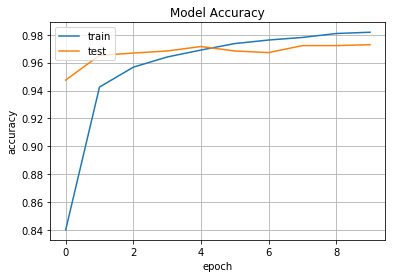


Test Error: 3.11%



In [16]:
preds = Pruned_LeNet.evaluate(x_test, y_test, batch_size=batch_size)
plot_trainings(trainings)
print("\nTest Error: {:.2%}\n".format(1-preds[1])) # should get 1.65ish error